In [1]:
from imposm.parser import OSMParser
import numpy as np
#import geopandas as gpd
import pandas as pd

In [47]:
osmfile='/media/tobiasseidel/OSM/power_plant.osm'

class Counter(object):
    CollectNodes=pd.DataFrame()
    CollectWays=pd.DataFrame()
    CollectCoords=pd.DataFrame()
    CollectRelations=pd.DataFrame()
    
    def ways(self, ways):
        for way in ways:
            C=pd.DataFrame([way[0],way[1],way[2:]]).transpose()
            C.columns=["id","tags","refs"]
            self.CollectWays=self.CollectWays.append(C)
    def coords(self,coordinates):
        for nid,coord0,coord1 in coordinates:
            C=pd.DataFrame([nid,coord0,coord1]).transpose()
            C.columns=["id","x","y"]
            self.CollectCoords=self.CollectCoords.append(C)
    def nodes(self,nodes):
        for nid,tags,coords in nodes:
            C=pd.DataFrame([nid,tags,coords[0],coords[1]]).transpose()
            C.columns=["id","tags","x","y"]
            self.CollectNodes=self.CollectNodes.append(C)
            #break #only take the first
        
    def relations(self,relations):
        for nid,tags,rels in relations:
            C=pd.DataFrame([nid,tags,rels]).transpose()
            C.columns=["id","tags","rels"]
            self.CollectRelations=self.CollectRelations.append(C)

    def findTag(self,key,value=None,notin=None,nokey=False,unfold=None):
        """
        if value is not None: function returns ways, where the key has the value
        if notin is not None: function returns ways, where the key has a value not in the list
        if nokey is True: function returns ways, where the key is not in the tags list
        if unfold is not none: the list in unfold will be added to ways and taken from the tags
        """
        if nokey:
            ways = self.CollectWays[self.CollectWays.tags.map(lambda x: key not in x.keys())]
        else:
            withkey=self.CollectWays[self.CollectWays.tags.map(lambda x: key in x.keys())]
        
        if not notin is  None:
            ways=withkey[withkey.tags.map(lambda x: not x[key] in notin)]
        elif not nokey:
            ways=withkey[withkey.tags.map(lambda x: x[key].startswith(value))]
        
        #withkey=self.CollectNodes[self.CollectNodes.tags.map(lambda x: key in x.keys())]
        rel0=ways.refs.map(lambda x: x[0][0])
        relCoords=counter.CollectCoords.set_index("id").loc[rel0]
        ways["x"]=relCoords.x.values
        ways["y"]=relCoords.y.values
        if not unfold is None:
            for unfoldkey in unfold:
                ways[unfoldkey]=ways.tags.map(lambda x: x.get(unfoldkey))
        return ways
    

counter = Counter()

whitelist = set(('power', 'line'))

def tag_filter(tags):
  for key in tags.keys():
    if key not in whitelist:
      del tags[key]
  if 'name' in tags and len(tags) == 1:
    # tags with only a name have no information
    # how to handle this element
    del tags['name']

p = OSMParser(concurrency=4, 
              ways_callback=counter.ways,
              coords_callback=counter.coords,
              nodes_callback=counter.nodes,
              relations_callback=counter.relations,
              #ways_tag_filter=tag_filter,
             )
p.parse(osmfile)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

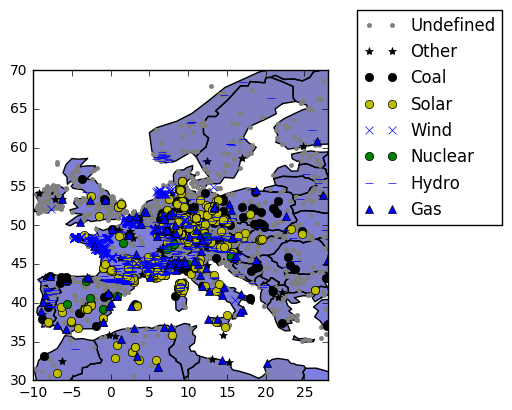

In [48]:
import geopandas as gpd
%pylab inline
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(column='pop_est')
xlim(-10,28)
ylim(30,70)


tounfold=["name","operator","plant:output:electricity","plant:output:hot_water"]
Undef=counter.findTag("generator:source",nokey=True,unfold=tounfold)
plot(Undef.x,Undef.y,".",label="Undefined",color="gray")
Other=counter.findTag("generator:source",notin=["coal","solar","wind","nuclear","hydro","gas"],unfold=tounfold)
plot(Other.x,Other.y,"*k",label="Other")
Coal=counter.findTag("generator:source","coal",unfold=tounfold)
plot(Coal.x,Coal.y,"ok",label="Coal")
Solar=counter.findTag("generator:source","solar",unfold=tounfold)
plot(Solar.x,Solar.y,"oy",label="Solar")
Wind=counter.findTag("generator:source","wind",unfold=tounfold)
plot(Wind.x,Wind.y,"xb",label="Wind")
Nuclear=counter.findTag("generator:source","nuclear",unfold=tounfold)
plot(Nuclear.x,Nuclear.y,"og",label="Nuclear")
Hydro=counter.findTag("generator:source","hydro",unfold=tounfold)
plot(Hydro.x,Hydro.y,"_b",label="Hydro")
Gas=counter.findTag("generator:source","gas",unfold=tounfold)
plot(Gas.x,Gas.y,"^b",label="Gas")

legend(loc=(1.1,0.5))


In [49]:
Coal

,id,tags,refs,x,y,name,operator,plant:output:electricity,plant:output:hot_water
0,23681460,{u'website': u'http://www.kraftwerk-mehrum.de'...,"([330099423, 1073288758, 323206232, 582811235,...",10.093734,52.311207,Gemeinschaftskraftwerk Mehrum,Kraftwerk Mehrum GmbH,750 MW,None
0,24267119,{u'note': u'Nach Angaben der BNetzA sind die B...,"([262731146, 262731147, 2371633105, 262731148,...",6.576813,51.061901,RWE Kraftwerk Frimmersdorf,None,562 MW,None
0,24694956,"{u'name:en': u'""Orot Rabin"" Power Stations Sit...","([268426889, 1126575112, 1126575121, 268426890...",34.886701,32.476247,"אתר תחנות-הכוח ""אורות רבין""",None,yes,None
0,24840439,"{u'note:de': u'Umriss Kraftwerk Niederaußem', ...","([269894035, 306217309, 379503267, 379503263, ...",6.664164,50.996170,Kraftwerk Niederaußem,RWE Power AG,3430 MW,None
0,25649285,{u'int_name': u'Evonik Steag Gmbh Powerplant H...,"([279452207, 279598911, 279598912, 279598923, ...",7.180699,51.549907,Kraftwerk Herne Baukau,Evonik Industries AG,960 MW,None
0,25898809,"{u'plant:output:hot_water': u'1561 MW', u'powe...","([282511371, 3179699461, 3179699356, 317969935...",20.985866,52.294784,Elektrociepłownia Żerań,PGNiG TERMIKA,350 MW,1561 MW
0,26389159,"{u'name': u'Kraftwerk Rostock', u'power': u'pl...","([289103944, 1135999446, 331439219, 331439218,...",12.132357,54.145530,Kraftwerk Rostock,None,508 MW,None
0,26724246,"{u'name': u'Kraftwerk Stuttgart-Münster', u'po...","([293118393, 1579855436, 1579855460, 157985547...",9.217050,48.812722,Kraftwerk Stuttgart-Münster,None,179.4 MW,None
0,27315902,"{u'end_date': u'2015-04-24', u'barrier': u'fen...","([299834023, 4446891374, 4446891372, 444689137...",2.414028,48.792981,Centrale Thermique de Vitry-sur-Seine,Électricité de France,500 MW,None
0,28051874,"{u'name': u'Kraftwerk Bexbach', u'power': u'pl...","([308028464, 2473451134, 2473451133, 247331855...",7.235556,49.361522,Kraftwerk Bexbach,None,773 MW,None


In [58]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure,ColumnDataSource
from bokeh.models import WMTSTileSource,HoverTool
from pyproj import Proj, transform
from bokeh.resources import INLINE

from_proj = Proj(init="epsg:4326")
to_proj = Proj(init="epsg:3857")

def genSource(df):
    df['mx']=0
    df['my']=0
    
    df.mx,df.my = transform(from_proj, to_proj, df.x.values, df.y.values)
    source = ColumnDataSource(
            data=dict(
                x=df.mx.values,#
                y=df.my.values,#
                lat=df.x.values,
                lon=df.y.values,
                wid=df.id.values,#way id
                name=df.name.values,
                operator=df.operator.values,
                plant_output_electricity=df['plant:output:electricity'].values,
                plant_output_hot_water=df['plant:output:hot_water'].values,
            )
        )
    return source

hover = HoverTool(
        tooltips=[
            #("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("(lat,lon)", "(@lat, @lon)"),
            ("id", "@wid"),
            ("name", "@name"),
            ("operator", "@operator"),
            ("power", "@plant_output_electricity"),
            
        ]
    )


output_notebook(resources=INLINE)



bound = 20000000 # meters
fig = figure(tools=['pan','wheel_zoom','reset',hover], x_range=(-1e6, 4e6), y_range=(4.5e6, 8e6))
fig.axis.visible = False

osm=WMTSTileSource(url='http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png')

fig.add_tile(osm)


fig.circle("x","y",
           color="lightblue",size=5,line_width=1,line_color="black",
           legend="Undefined",source=genSource(Undef))

fig.circle("x","y",
           color="lightgreen",size=5,line_width=1,line_color="black",
           legend="Other",source=genSource(Other))

fig.circle("x","y",
           color="black",size=10,
           legend="Coal",source=genSource(Coal))

fig.circle("x","y",
           color="yellow",size=10,line_width=1,line_color="black",
           legend="Nuclear",source=genSource(Nuclear))

fig.circle("x","y",
           color="blue",size=4,
           legend="Wind",source=genSource(Wind))

fig.circle("x","y",
           color="orange",size=4,
           legend="Solar",source=genSource(Solar))

fig.circle("x","y",
           color="green",size=4,
           legend="Hydro",source=genSource(Hydro))

fig.circle("x","y",
           color="lightgreen",size=4,
           legend="Gas",source=genSource(Gas))

Loading BokehJS ...

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


GlyphRenderer(id='290803be-5f51-4705-bb62-7a08efe9020c', ...)

## Bokeh plot of all power plants in europe mapped in OSM

In [59]:
show(fig)